# ParkEase:

**Name:** Arin Deloatch, Ksenia Kold, Paul Thai
**Date:** January 30, 2024  
**Class:** AAI-530 Data Analytics and Internet of Things  
**Professor:** Professor Roozbeh Sadeghian

In [60]:
# Import Libraries
import keras
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, SimpleRNN, GlobalAveragePooling1D, TimeDistributed
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [61]:
# Read in the file
df = pd.read_csv("http://iot.ee.surrey.ac.uk:8080/datasets/parking/aarhus_parking.csv")

# Saving a copy (just in case) + checking if file already exists
csv_file = "aarhus_parking.csv"

# Grab current working directory
work_dir = os.getcwd()

# Perform a check
if csv_file in os.listdir(work_dir):
  print(f"{csv_file} already exists... continuing")
else:
  df.to_csv(csv_file)
  print(f"Finished downloading {csv_file}, moving on")

aarhus_parking.csv already exists... continuing


### Helper Functions

In [62]:
# Function to create sequences and labels
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

### EDA: Exploration Data Analysis

In [63]:
# Peeking at the meta information from the dataset
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55264 entries, 0 to 55263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vehiclecount  55264 non-null  int64 
 1   updatetime    55264 non-null  object
 2   _id           55264 non-null  int64 
 3   totalspaces   55264 non-null  int64 
 4   garagecode    55264 non-null  object
 5   streamtime    55264 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.5+ MB


In [64]:
print(f"Dataframe columns: {df.columns}")
print(f"Dataframe length: {len(df)}")

Dataframe columns: Index(['vehiclecount', 'updatetime', '_id', 'totalspaces', 'garagecode',
       'streamtime'],
      dtype='object')
Dataframe length: 55264


In [65]:
# Check for NA values
df.isna().sum()

vehiclecount    0
updatetime      0
_id             0
totalspaces     0
garagecode      0
streamtime      0
dtype: int64

In [66]:
# Check for null values
df.isnull().sum()

vehiclecount    0
updatetime      0
_id             0
totalspaces     0
garagecode      0
streamtime      0
dtype: int64

In [67]:
# Taking a look at the first couple rows
df.head(20)

vehiclecount               updatetime  _id  totalspaces     garagecode  \
0              0  2014-05-22 09:09:04.145    1           65      NORREPORT   
1              0  2014-05-22 09:09:04.145    2          512    SKOLEBAKKEN   
2            869  2014-05-22 09:09:04.145    3         1240    SCANDCENTER   
3             22  2014-05-22 09:09:04.145    4          953         BRUUNS   
4            124  2014-05-22 09:09:04.145    5          130   BUSGADEHUSET   
5            106  2014-05-22 09:09:04.145    6          400        MAGASIN   
6            115  2014-05-22 09:09:04.145    7          210  KALKVAERKSVEJ   
7            233  2014-05-22 09:09:04.145    8          700        SALLING   
8              0  2014-05-22 09:39:01.803    9           65      NORREPORT   
9              0  2014-05-22 09:39:01.803   10          512    SKOLEBAKKEN   
10           959  2014-05-22 09:39:01.803   11         1240    SCANDCENTER   
11            22  2014-05-22 09:39:01.803   12          953         BRUUNS   
12           124  2014-05-22 09:39:01.803   13          130   BUSGADEHUSET   
13           119  2014-05-22 09:39:01.803   14          400        MAGASIN   
14           121  2014-05-22 09:39:01.803   15          210  KALKVAERKSVEJ   
15           282  2014-05-22 09:39:01.803   16          700        SALLING   
16             0  2014-05-22 10:10:51.543   17           65      NORREPORT   
17             0  2014-05-22 10:10:51.543   18          512    SKOLEBAKKEN   
18          1014  2014-05-22 10:10:51.543   19         1240    SCANDCENTER   
19            22  2014-05-22 10:10:51.543   20          953         BRUUNS   

             streamtime  
0   2014-11-03 16:18:44  
1   2014-11-03 16:18:44  
2   2014-11-03 16:18:44  
3   2014-11-03 16:18:44  
4   2014-11-03 16:18:44  
5   2014-11-03 16:18:44  
6   2014-11-03 16:18:44  
7   2014-11-03 16:18:44  
8   2014-11-03 16:18:44  
9   2014-11-03 16:18:44  
10  2014-11-03 16:18:44  
11  2014-11-03 16:18:44  
12  2014-11-03 16:18:44  
13  2014-11-03 16:18:44  
14  2014-11-03 16:18:44  
15  2014-11-03 16:18:44  
16  2014-11-03 16:18:44  
17  2014-11-03 16:18:44  
18  2014-11-03 16:18:44  
19  2014-11-03 16:18:44

In [68]:
# Checking for valid garage codes + unique codes
total_gcodes = len(df.garagecode)
total_unique_gcodes = len(df.garagecode.unique())
print(f"Unique garage codes", df.garagecode.unique())
print(f"There are {total_gcodes} total garage codes")
print(f"There are {total_unique_gcodes} unique garage codes")

Unique garage codes ['NORREPORT' 'SKOLEBAKKEN' 'SCANDCENTER' 'BRUUNS' 'BUSGADEHUSET' 'MAGASIN'
 'KALKVAERKSVEJ' 'SALLING']
There are 55264 total garage codes
There are 8 unique garage codes


In [69]:
# Visualize + Check for any uneven distribution
value_count = df.garagecode.value_counts()
df_count = pd.DataFrame({'GarageCode': value_count.index, 'Ammount': value_count.values})
fig = px.bar(df_count, x='GarageCode', y = 'Ammount', title="Unique Garage Codes", color='GarageCode')
fig.show()


#### Conclusions 1
*   We have **55264** entries in the dataset
*   At the first glance the date seems clean and well organized
*   Each entry provides all of the attributes
*   Next, we will need to check the data **quality** and if there are any issues with the data itself
*   Let's convert updatetime and streamtime to the `pd.datetime` format



In [70]:
# Convert 'streamtime' column to datetime
df['streamtime'] = pd.to_datetime(df['streamtime'], format='%Y-%m-%d %H:%M:%S')
# Convert 'updatetime' column to datetime
df['updatetime'] = pd.to_datetime(df['updatetime'], format='mixed')

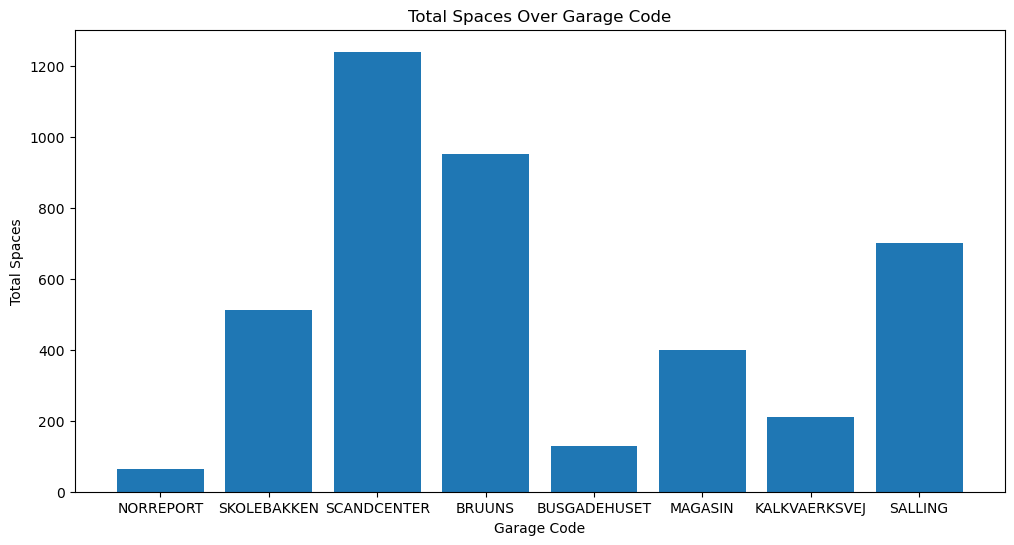

In [71]:
# Bar chart for 'totalspaces' over 'garagecode' use plt
plt.figure(figsize=(12, 6))
plt.bar(df['garagecode'], df['totalspaces'])
plt.title('Total Spaces Over Garage Code')
plt.xlabel('Garage Code')
plt.ylabel('Total Spaces')
plt.show()

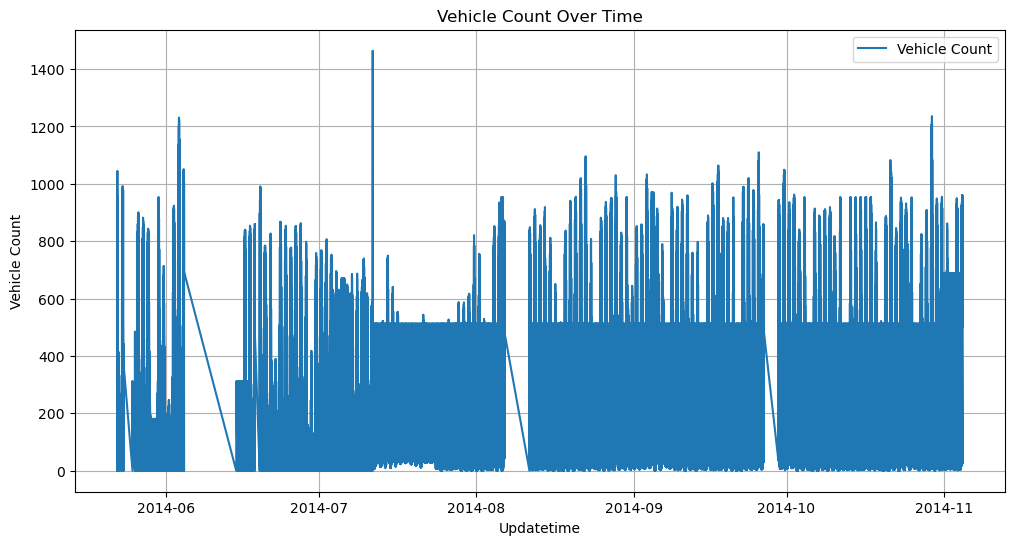

In [72]:
# Line plot of 'vehiclecount' over 'updatetime'
plt.figure(figsize=(12, 6))
plt.plot(df['updatetime'], df['vehiclecount'], label='Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.xlabel('Updatetime')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.show()

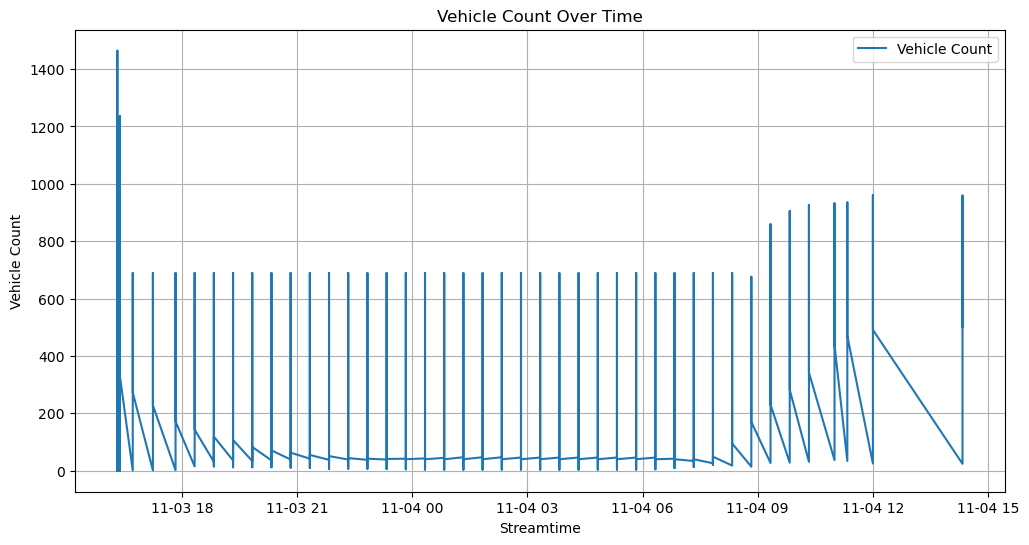

In [73]:
# Line plot of 'vehiclecount' over 'streamtime'
plt.figure(figsize=(12, 6))
plt.plot(df['streamtime'], df['vehiclecount'], label='Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.xlabel('Streamtime')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusions 2
*  From the dataset description the difference between streamline and updatetime was not clear.
*  From the plots above we can see that we have more updatetime datapoints compared to the streamtime.
*  Let's check the difference between streamtime and updatetime.



In [74]:
# Get unique streamtime_values
unique_streamtime_values = df['streamtime'].unique()
print(f"Unique streamtime values: {unique_streamtime_values}")
print(f"Unique streamtime values length: {len(unique_streamtime_values)}")

Unique streamtime values: <DatetimeArray>
['2014-11-03 16:18:44', '2014-11-03 16:19:11', '2014-11-03 16:19:40',
 '2014-11-03 16:20:08', '2014-11-03 16:22:16', '2014-11-03 16:22:34',
 '2014-11-03 16:23:01', '2014-11-03 16:43:16', '2014-11-03 17:14:47',
 '2014-11-03 17:50:09', '2014-11-03 18:20:01', '2014-11-03 18:50:01',
 '2014-11-03 19:20:02', '2014-11-03 19:50:02', '2014-11-03 20:20:01',
 '2014-11-03 20:50:01', '2014-11-03 21:20:02', '2014-11-03 21:50:01',
 '2014-11-03 22:20:02', '2014-11-03 22:50:01', '2014-11-03 23:20:02',
 '2014-11-03 23:50:02', '2014-11-04 00:20:02', '2014-11-04 00:50:02',
 '2014-11-04 01:20:01', '2014-11-04 01:50:01', '2014-11-04 02:20:01',
 '2014-11-04 02:50:02', '2014-11-04 03:20:01', '2014-11-04 03:50:01',
 '2014-11-04 04:20:02', '2014-11-04 04:50:04', '2014-11-04 05:20:01',
 '2014-11-04 05:50:02', '2014-11-04 06:20:02', '2014-11-04 06:50:01',
 '2014-11-04 07:20:01', '2014-11-04 07:50:01', '2014-11-04 08:20:02',
 '2014-11-04 08:50:01', '2014-11-04 09:20:03', '

In [75]:
# Get the minimum 'streamtime'
min_streamtime = df['streamtime'].min()

# Get the maximum 'streamtime'
max_streamtime = df['streamtime'].max()

print(f"Minimum Streamtime: {min_streamtime}")
print(f"Maximum Streamtime: {max_streamtime}")

Minimum Streamtime: 2014-11-03 16:18:44
Maximum Streamtime: 2014-11-04 14:20:03


In [76]:
# Get the minimum 'updatetime'
min_updatetime = df['updatetime'].min()

# Get the maximum 'updatetime'
max_updatetime = df['updatetime'].max()

print(f"Minimum Update time: {min_updatetime}")
print(f"Maximum Update time: {max_updatetime}")

Minimum Update time: 2014-05-22 09:09:04.145000
Maximum Update time: 2014-11-04 14:13:47.581000


#### Conclusions 3
* Streamtime ranges between 2 dates 2014-11-03 and 2014-11-04
* These were the dates when the data uploaded to the server
* Updatetime ranges between dates 2014-05-22 and 2014-11-04
* These were the date times when the parking garages reported on the vehcile counts
* **We are interested in predictions based in the `updatetime`, and will not be using `streamtime`**
* From the plot of `vehcilecount` over the `updatetime`, it seemed that we had some missing dates in our data set. Let's explore.


In [77]:
# Find the minimum and maximum timestamps
min_timestamp = df['updatetime'].dt.date.min()
max_timestamp = df['updatetime'].dt.date.max()

# Generate a date range from the minimum to the maximum timestamp
expected_dates = pd.date_range(start=min_timestamp, end=max_timestamp, freq='D')
actual_dates = pd.to_datetime(df['updatetime'].dt.date.unique())


# Check for missing timestamps
missing_timestamps = expected_dates[~expected_dates.isin(actual_dates)]

missing_timestamps_df =  pd.DataFrame(missing_timestamps, columns=['missing_timestamps'])

if missing_timestamps.empty:
    print("No missing timestamps found.")
else:
    print("Missing timestamps found:")
    display(missing_timestamps_df.head(100))
    print(f"Total missing timestamps: {len(missing_timestamps)}")

Missing timestamps found:


missing_timestamps
0          2014-05-24
1          2014-06-05
2          2014-06-06
3          2014-06-07
4          2014-06-08
5          2014-06-09
6          2014-06-10
7          2014-06-11
8          2014-06-12
9          2014-06-13
10         2014-08-07
11         2014-08-08
12         2014-08-09
13         2014-08-10
14         2014-09-27
15         2014-09-28

Total missing timestamps: 16


count       mean         std       min      25%   50%  \
garagecode                                                              
BRUUNS         6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
BUSGADEHUSET   6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
KALKVAERKSVEJ  6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
MAGASIN        6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
NORREPORT      6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SALLING        6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SCANDCENTER    6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SKOLEBAKKEN    6907.0  34.652486  205.318242  0.000033  29.9999  30.0   

                   75%           max  
garagecode                            
BRUUNS         30.0001  14747.039983  
BUSGADEHUSET   30.0001  14747.039983  
KALKVAERKSVEJ  30.0001  14747.039983  
MAGASIN        30.0001  14747.039983  
NORREPORT      30.0001  14747.039983  
SALLING        30.0001  14747.039983  
SCANDCENTER    30.0001  14747.039983  
SKOLEBAKKEN    30.0001  14747.039983

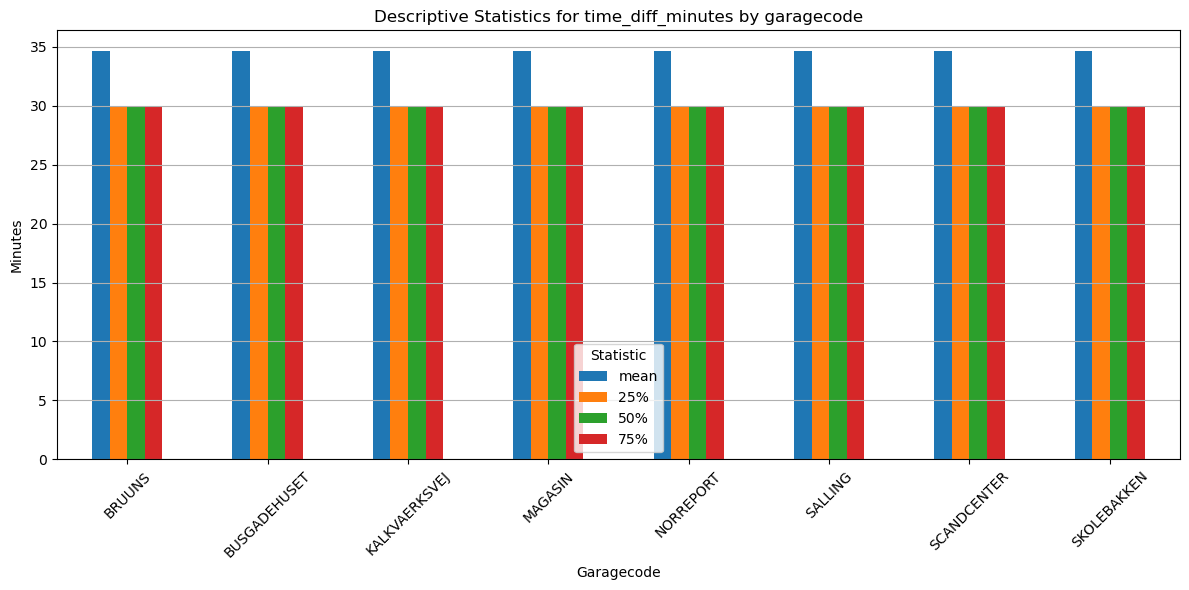

In [78]:
# Check the frequency of the reporting
df_diff = df.copy()

# Sort by garagecode and updatetime
df_diff = df_diff.sort_values(['garagecode', 'updatetime'])

# Calculate the time difference for each garagecode
df_diff['time_diff_minutes'] = df_diff.groupby('garagecode')['updatetime'].diff() / pd.Timedelta(minutes=1)

# Plot descriptive statistics for time_diff_minutes for each garagecode separately
garagecode_groups = df_diff.groupby('garagecode')['time_diff_minutes']
garagecode_stats = garagecode_groups.describe()

display(garagecode_stats)

# Plot boxplots
garagecode_stats[['mean', '25%', '50%', '75%']].plot(kind='bar', figsize=(12, 6))
plt.ylabel('Minutes')
plt.xlabel('Garagecode')
plt.title('Descriptive Statistics for time_diff_minutes by garagecode')
plt.xticks(rotation=45)
plt.legend(title='Statistic')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Conclusions 4
* We have totla of **16 dates** missing from the dataset.
* For each garage most of the data is reported with the difference of **30 minutes**
* Let's also investigate what data was reported per each garage.

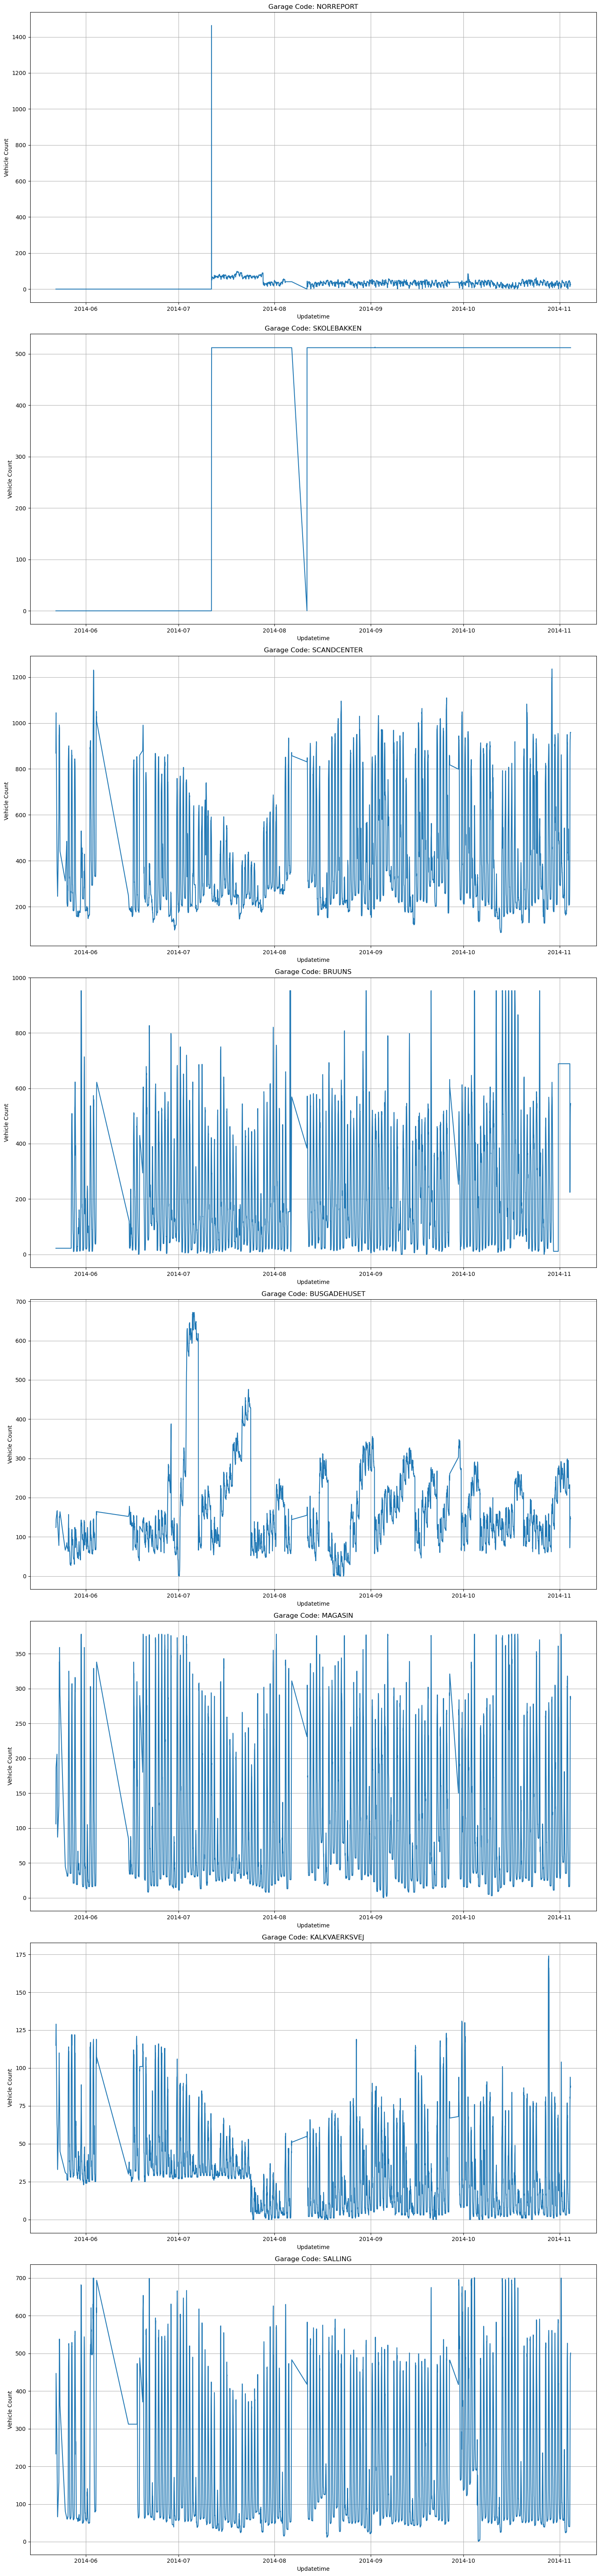

In [79]:
garage_codes = df['garagecode'].unique()

# Create subplots
fig, axes = plt.subplots(len(garage_codes), figsize=(15, 8*len(garage_codes)))

# Iterate through each garage code
for i, code in enumerate(garage_codes):
    # Filter dataframe for current garage code
    sub_df = df[df['garagecode'] == code]

    # Plot vehicle count against timestamp
    axes[i].plot(sub_df['updatetime'], sub_df['vehiclecount'])
    axes[i].set_title(f'Garage Code: {code}')
    axes[i].set_xlabel('Updatetime')
    axes[i].set_ylabel('Vehicle Count')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Conclusions - EDA and Data Quality
-  We have **55264** entries in the dataset
- There is total of **16** missing dates when no `vehiclecount` was reported. This amounts to $\approx 768$ missing entries, since for every day the data is reported every 30 minutes.
- Looks like June and August and September have missing entries. Those missing entries are consistent across oll of the garage codes.
- Additionally, it seems there might be data quality issues per garage level:
  * SKOLEBAKKEN - was probably used for a company's vehicles parking or similar, since vehicle count did not change across multiple days
  * NORREPORT has 0 cars parked up to mid July, then an outlier day with 1400 parked, following days with under 200 cars parked
  * KALKVAERKSVEJ - up to mid July KALKVAERKSVEJ always had at least 25 cars parked permanently
  * Data for the remaining garages - SCANDCENTER, BRUUNS, BUSGADEHUSET and MAGASIN and SALLING looks to be in a good shape, besides the 16 missing dates

### Preprocessing the Dataset

Given the conclusion above, we decided to do the following preprocessing steps:

- Normalize data to increase model performance and prevent issues, such as gradient explosion and vanishing
- We will not be backfilling missing dates, since this will result in a loss of a temporal pattern, instead we will focus on efficiently using the existing data
- Every garage has slightly different patterns of occupancy depending on the date / time. From our predict perspective it makes sense to provide a Garage level APIs, thus we will be training models for each garage separately

In [80]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

### Creating the LSTM Model

In [81]:
# Set sequence length
sequence_length = 10

In [82]:
# Create a dictionary to hold the values to visualize
results = {}

In [83]:
for area_id, area_data in df.groupby('garagecode'):
    # Extracting only the occupancy values
    occupancy = area_data[['vehiclecount']]

    # Normalize the occupancy dataset
    occupancy_scaled = scaler.fit_transform(occupancy)

    # Create sequences and labels
    X, y = create_sequences(occupancy_scaled, sequence_length)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Define the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(64,input_shape=(sequence_length,1),return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('linear'))

    # Model Path
    model_path = "model_lstm.h5"

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Predict occupancy values on testing set
    y_test_pred = model.predict(X_test)

    # Inverse transform the predicted and actual values to their original scale
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)

    # Store results in the dictionary
    results[area_id] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'mae': mae,
        'mse': mse,
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'y_test_pred': y_test_pred,
        'y_test': y_test
    }

Epoch 1/20
164/164 - 24s - loss: 0.0188 - val_loss: 0.0055 - 24s/epoch - 146ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0080 - val_loss: 0.0128 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0076 - val_loss: 0.0040 - 7s/epoch - 44ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0369 - val_loss: 0.0459 - 7s/epoch - 40ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0628 - val_loss: 0.0333 - 6s/epoch - 39ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0136 - val_loss: 0.0225 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0215 - val_loss: 0.0541 - 6s/epoch - 39ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0268 - val_loss: 0.0331 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0315 - val_loss: 0.0207 - 6s/epoch - 39ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0384 - val_loss: 0.0463 - 6s/epoch - 37ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0158 - val_loss: 0.0398 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0451 - val_loss: 0.1436 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0232 - val_loss: 0.0924 - 6s/epoch - 37ms/step
44/44 [============================

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0031 - val_loss: 0.0023 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0022 - val_loss: 0.0014 - 7s/epoch - 41ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0019 - val_loss: 9.5617e-04 - 6s/epoch - 39ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0018 - val_loss: 8.9854e-04 - 6s/epoch - 39ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0023 - val_loss: 0.0021 - 6s/epoch - 37ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0021 - val_loss: 0.0018 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0016 - val_loss: 0.0011 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0019 - val_loss: 8.3065e-04 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0015 - val_loss: 0.0022 - 6s/epoch - 37ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0024 - val_loss: 0.0020 - 6s/epoch - 37ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0013 - val_loss: 0.0026 - 6s/epoch - 37ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0015 - val_loss: 0.0018 - 6s/epoch - 39ms/step
Epoch 14/20
164/164 - 6

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0042 - val_loss: 0.0051 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0045 - val_loss: 0.0056 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0045 - val_loss: 0.0035 - 6s/epoch - 39ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0037 - val_loss: 0.0049 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0037 - val_loss: 0.0066 - 6s/epoch - 39ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0081 - val_loss: 0.0073 - 6s/epoch - 37ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0045 - val_loss: 0.0035 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0034 - val_loss: 0.0038 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0075 - val_loss: 0.0068 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0024 - val_loss: 0.0074 - 6s/epoch - 37ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0019 - val_loss: 0.0054 - 6s/epoch - 37ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0017 - val_loss: 0.0044 - 6s/epoch - 37ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0052 - val_loss: 0.0091 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0193 - val_loss: 0.1149 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0462 - val_loss: 0.0136 - 6s/epoch - 39ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0250 - val_loss: 0.0288 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0216 - val_loss: 0.0068 - 6s/epoch - 39ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0061 - val_loss: 0.0201 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0082 - val_loss: 0.0449 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0149 - val_loss: 0.0444 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0329 - val_loss: 0.0543 - 6s/epoch - 36ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0578 - val_loss: 0.0302 - 6s/epoch - 36ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0283 - val_loss: 0.0847 - 6s/epoch - 37ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0183 - val_loss: 0.0067 - 6s/epoch - 37ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0091 - val_loss: 0.0642 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0010 - val_loss: 0.0711 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0011 - val_loss: 0.0738 - 7s/epoch - 40ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0013 - val_loss: 0.0850 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0015 - val_loss: 0.0752 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0044 - val_loss: 0.0664 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0043 - val_loss: 0.0496 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0024 - val_loss: 0.0487 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0169 - val_loss: 0.0018 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0118 - val_loss: 4.8480e-04 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 7.5359e-04 - val_loss: 3.1530e-04 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 6s - loss: 6.7134e-04 - val_loss: 2.1244e-04 - 6s/epoch - 38ms/step
Epoch 14/20
164

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0080 - val_loss: 0.0088 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0043 - val_loss: 0.0094 - 7s/epoch - 41ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0100 - val_loss: 0.0230 - 7s/epoch - 40ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0167 - val_loss: 0.0062 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0106 - val_loss: 0.0289 - 6s/epoch - 39ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0100 - val_loss: 0.0399 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0081 - val_loss: 0.0341 - 6s/epoch - 39ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0072 - val_loss: 0.0319 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0099 - val_loss: 0.0219 - 6s/epoch - 39ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0211 - val_loss: 0.0200 - 6s/epoch - 37ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0109 - val_loss: 0.0301 - 6s/epoch - 37ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0138 - val_loss: 0.0178 - 6s/epoch - 37ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0147 - val_loss: 0.0060 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 8s - loss: 0.0092 - val_loss: 0.0196 - 8s/epoch - 46ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0124 - val_loss: 0.0049 - 7s/epoch - 43ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0079 - val_loss: 0.0063 - 7s/epoch - 42ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0068 - val_loss: 0.0065 - 6s/epoch - 39ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0154 - val_loss: 0.0095 - 7s/epoch - 40ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0099 - val_loss: 0.0110 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0084 - val_loss: 0.0168 - 6s/epoch - 39ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0051 - val_loss: 0.0114 - 6s/epoch - 40ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0077 - val_loss: 0.0210 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0113 - val_loss: 0.0128 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0055 - val_loss: 0.0101 - 6s/epoch - 39ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0011 - val_loss: 5.4736e-04 - 7s/epoch - 45ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0012 - val_loss: 0.0070 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0014 - val_loss: 4.1199e-04 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 9.7436e-04 - val_loss: 3.0383e-04 - 7s/epoch - 40ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0010 - val_loss: 7.8738e-05 - 6s/epoch - 39ms/step
Epoch 7/20
164/164 - 7s - loss: 9.8801e-04 - val_loss: 5.0876e-04 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 6s - loss: 9.7663e-04 - val_loss: 5.5570e-04 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0011 - val_loss: 1.5962e-04 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 7.9071e-04 - val_loss: 0.0015 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 6s - loss: 9.8670e-04 - val_loss: 8.0045e-05 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 8.1744e-04 - val_loss: 2.1101e-04 - 6s/epoch - 39ms/step
Epoch 13/20
164/164 - 6s - loss: 5.5009e-04 - val_loss: 8

In [84]:
def visualize_model(y_test, y_pred, num_samples=500):
    # Actual data
    last_n_actual = y_test[-num_samples:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_n_actual, label='Actual')
    # Predicted data
    last_n_predicted = y_pred[-num_samples:]
    plt.plot(last_n_predicted, label='Predicted')
    plt.title('Actual vs Predicted Vehicle Count')
    plt.xlabel('Index')
    plt.ylabel('Vehicle Count')
    plt.legend()
    plt.show()


In [85]:
def visualize_loss(loss, val_loss):
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print()


Parking Area: BRUUNS
Train Loss: 0.08010228723287582
Test Loss: 0.10706521570682526
MAE: 297.5622694448285
MSE: 97237.59668033899



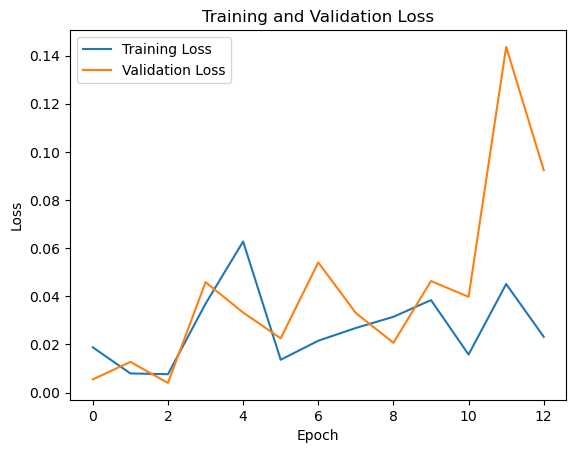

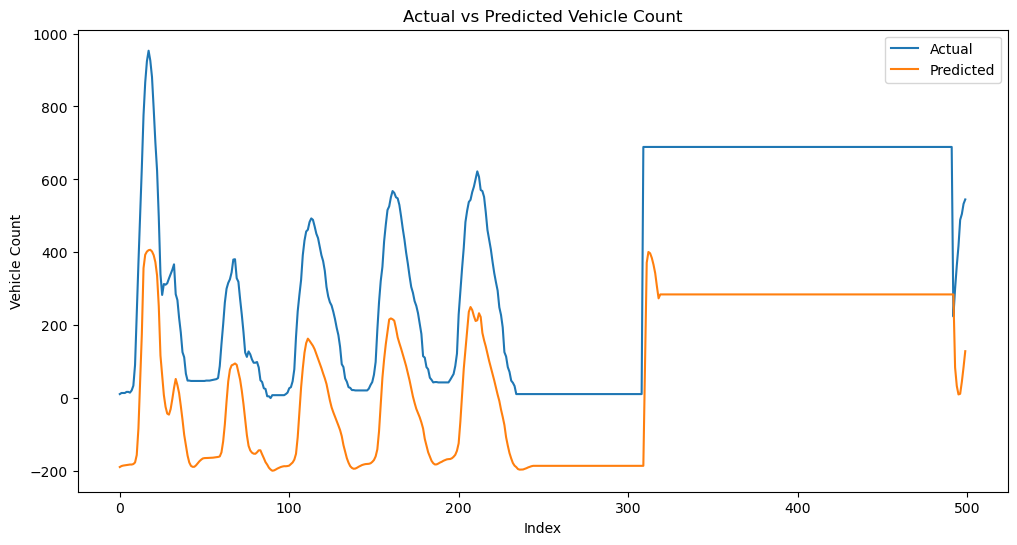

Parking Area: BUSGADEHUSET
Train Loss: 0.0032154275104403496
Test Loss: 0.0017863329267129302
MAE: 23.158173613617386
MSE: 806.6793227998508



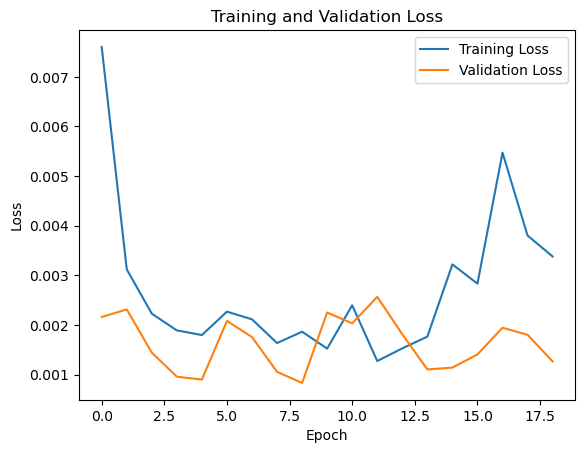

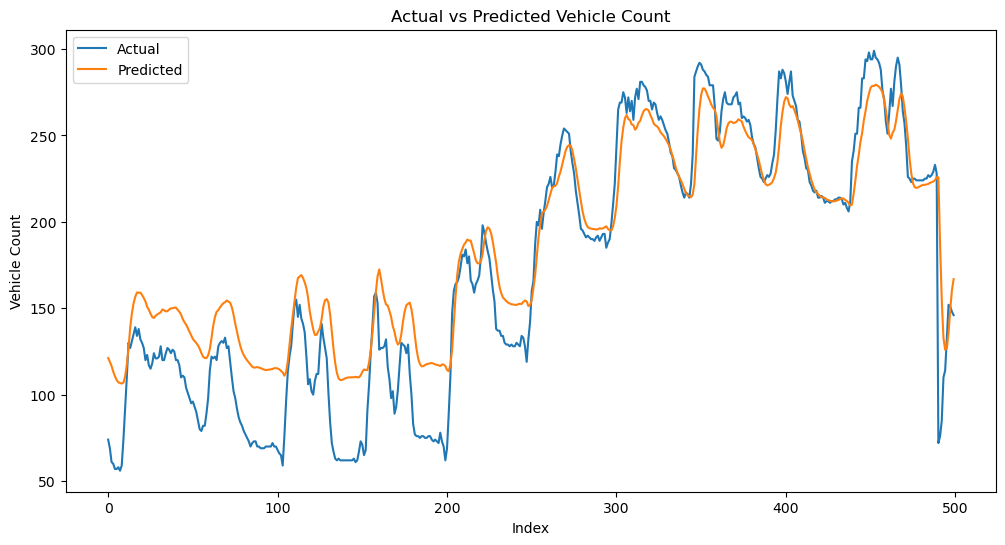

Parking Area: KALKVAERKSVEJ
Train Loss: 0.00335835968144238
Test Loss: 0.005429648794233799
MAE: 7.316454341721491
MSE: 164.38802525787784



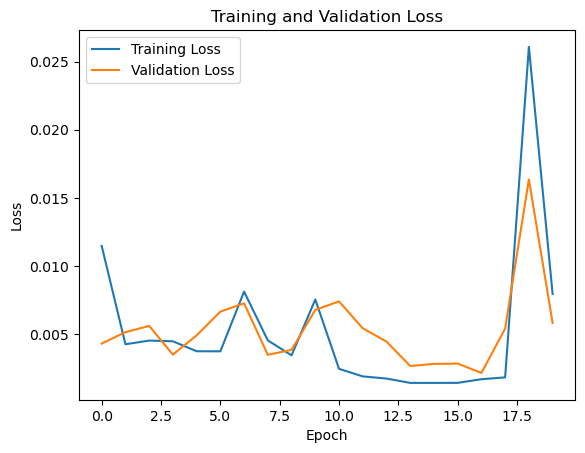

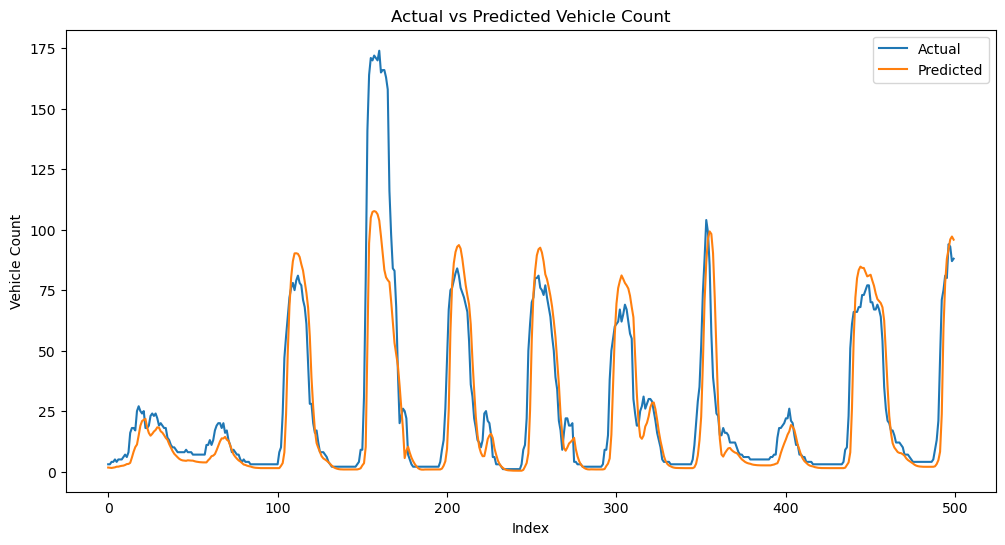

Parking Area: MAGASIN
Train Loss: 0.01622304692864418
Test Loss: 0.018605343997478485
MAE: 39.177857150202215
MSE: 2658.406677474203



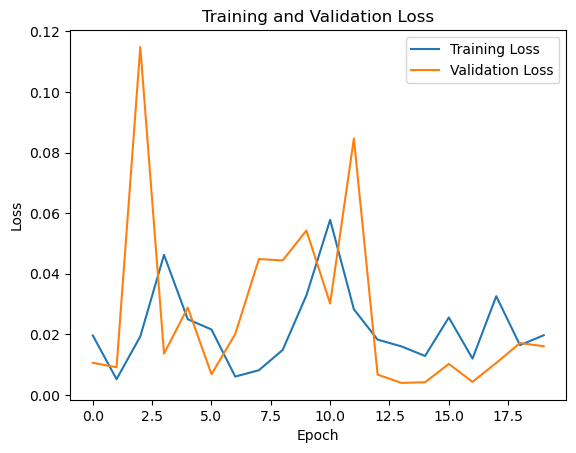

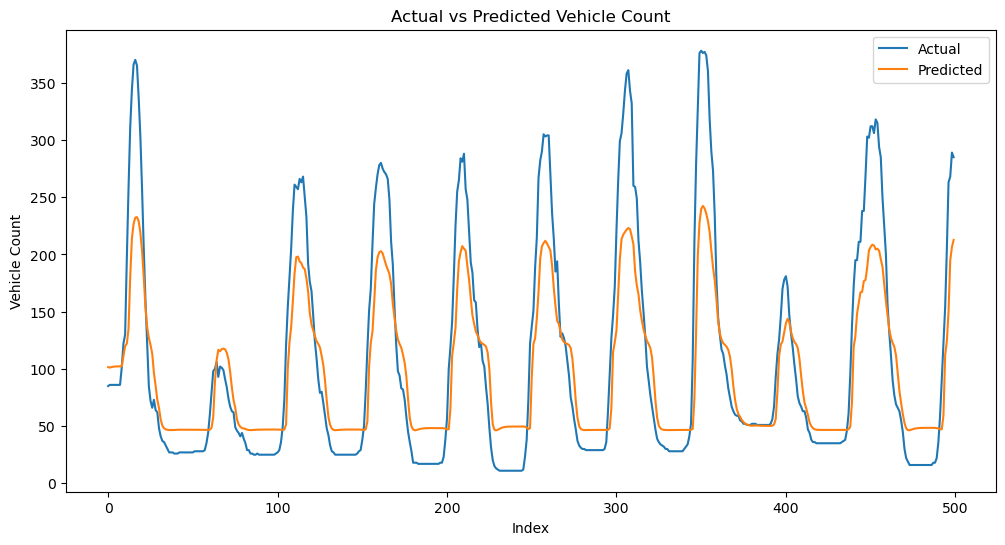

Parking Area: NORREPORT
Train Loss: 0.000538916268851608
Test Loss: 0.00014787954569328576
MAE: 14.51700291564499
MSE: 316.9496695149757



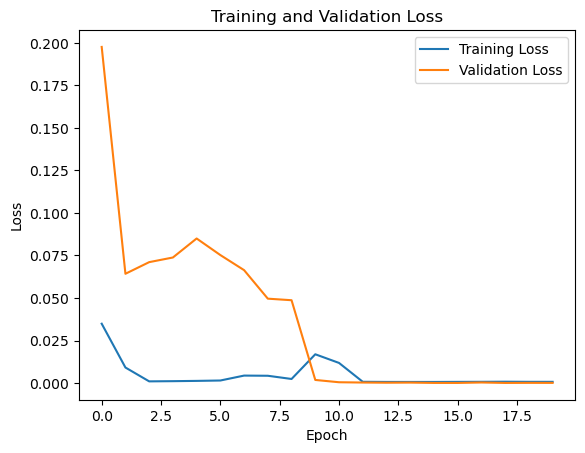

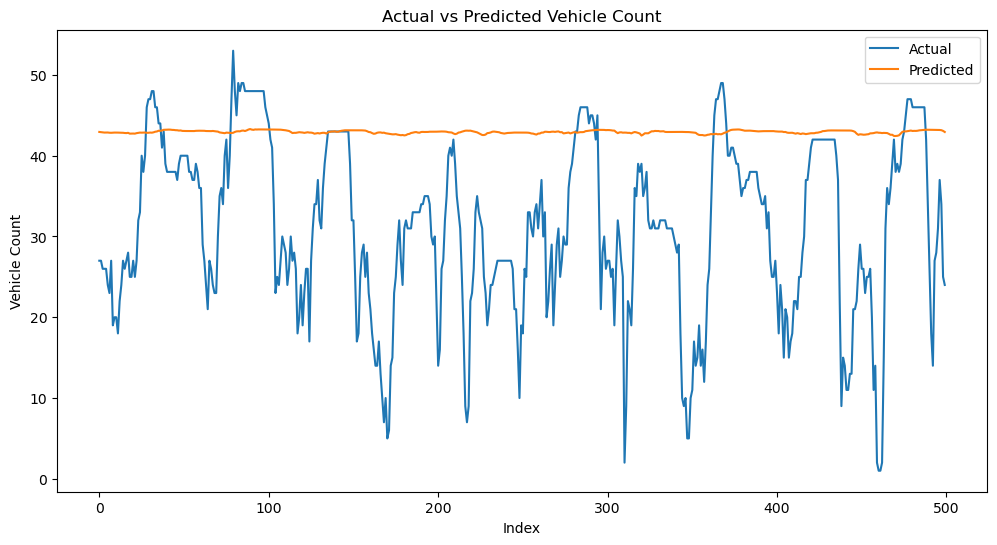

Parking Area: SALLING
Train Loss: 0.026109928265213966
Test Loss: 0.02553011104464531
MAE: 106.89223672618037
MSE: 12509.753425577794



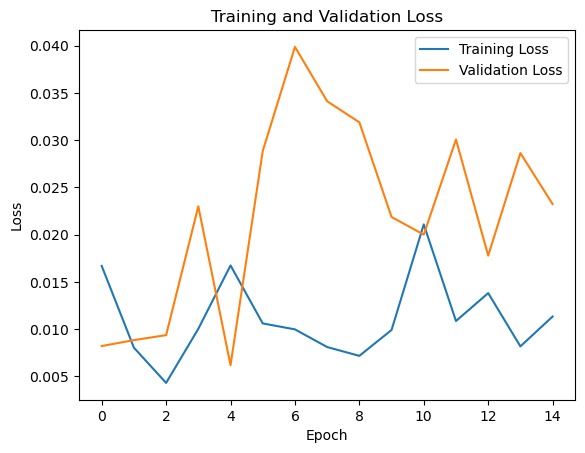

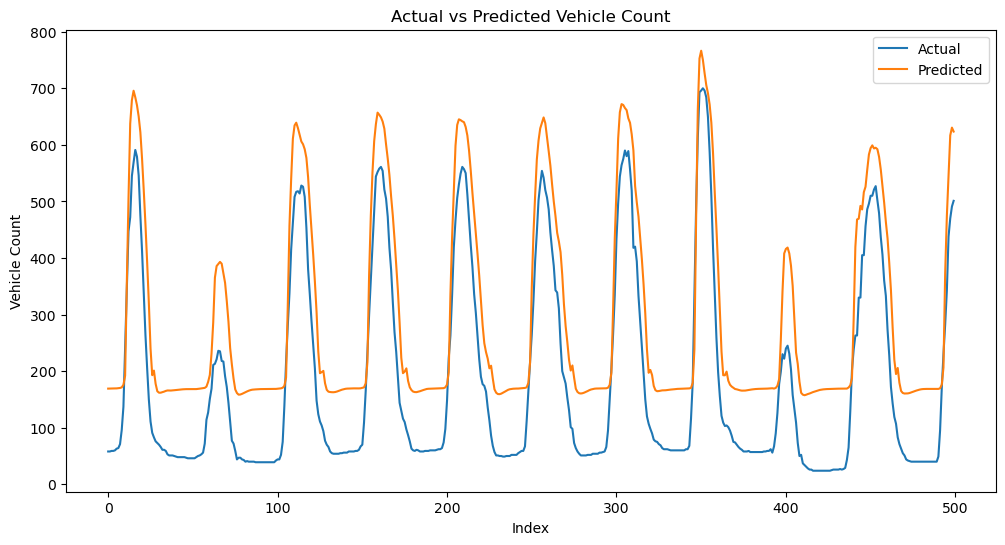

Parking Area: SCANDCENTER
Train Loss: 0.01286785863339901
Test Loss: 0.014482923783361912
MAE: 128.05201312078947
MSE: 19120.374364629246



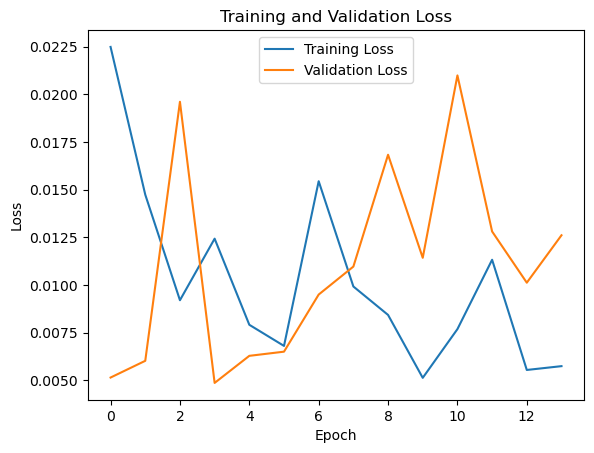

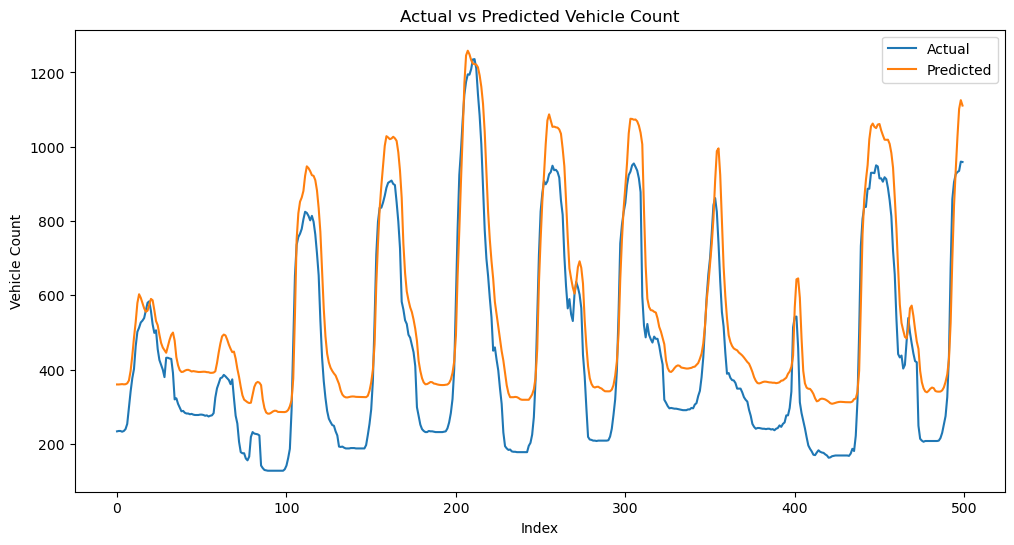

Parking Area: SKOLEBAKKEN
Train Loss: 0.017591601237654686
Test Loss: 0.008278668858110905
MAE: 46.67645263671875
MSE: 2178.6912307478487



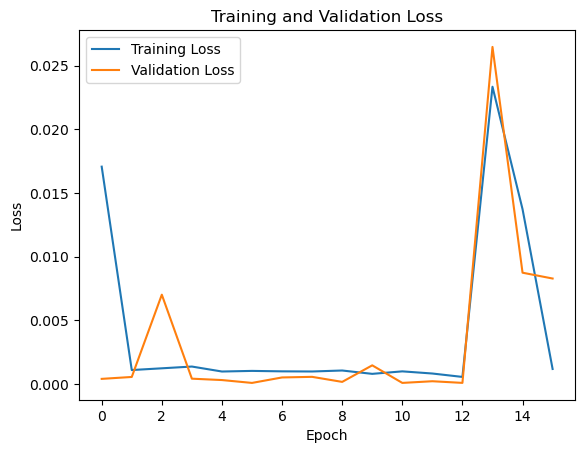

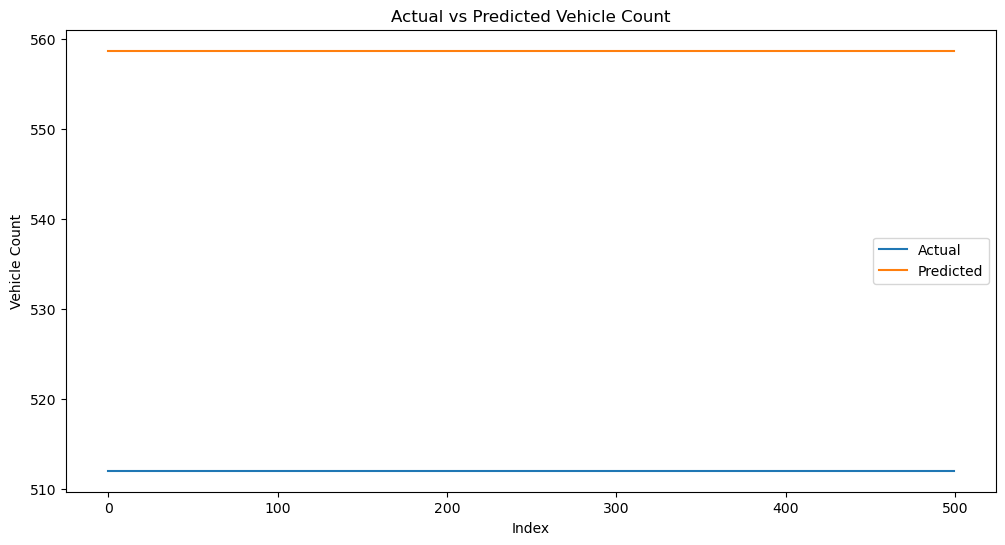

In [86]:
# Print results
for area_id, result in results.items():
    print(f"Parking Area: {area_id}")
    print(f"Train Loss: {result['train_loss']}")
    print(f"Test Loss: {result['test_loss']}")
    print(f"MAE: {result['mae']}")
    print(f"MSE: {result['mse']}")
    print()
    # Plot training and validation loss
    visualize_loss(result['loss'], result['val_loss'])
    # Plot actual vs predicted vehicle count
    visualize_model(result['y_test'], result['y_test_pred'])

### Creating the RNN Model

In [87]:
# Basing off the LSTM Model
# Create the results dictionary to store the RNN results
rnn_results = {}

In [88]:
for area_id, area_data in df.groupby('garagecode'):
    # Extracting only the occupancy values
    occupancy = area_data[['vehiclecount']]

    # Normalize the occupancy dataset
    occupancy_scaled = scaler.fit_transform(occupancy)

    # Create sequences and labels
    X, y = create_sequences(occupancy_scaled, sequence_length)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    print("Number of samples in X_train:", len(X_train))
    print("Number of samples in y_train:", len(y_train))
    print("Number of samples in X_train:", X_test.shape)
    print("Number of samples in y_train:", y_test.shape)
    # # Define the RNN model
    model = Sequential()
    model.add(SimpleRNN(2,input_shape=(sequence_length,1),return_sequences=True))
    model.add(TimeDistributed(Dense(units=1, activation='linear')))
    model.add(GlobalAveragePooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error')


    # Model Path
    model_path = "model_rnn.h5"

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    print("Number of samples in train_loss:", train_loss)
    print("Number of samples in test_loss:", test_loss)


    # Predict occupancy values on testing set
    y_test_pred = model.predict(X_test)

    print("Number of samples in y_test_pred:", len(y_test_pred))

    # Inverse transform the predicted and actual values to their original scale
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    print("Number of samples in y_test:", len(y_test))
    print("Number of samples in y_test_pred:", len(y_test_pred))

    # Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)

    # Store results in the dictionary
    rnn_results[area_id] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'mae': mae,
        'mse': mse,
        'loss':history.history['loss'],
        'val_loss':history.history['val_loss'],
        'y_test_pred': y_test_pred,
        'y_test': y_test
    }

Number of samples in X_train: 5518
Number of samples in y_train: 5518
Number of samples in X_train: (1380, 10, 1)
Number of samples in y_train: (1380, 1)
Epoch 1/20
164/164 - 10s - loss: 0.2253 - val_loss: 0.1503 - 10s/epoch - 63ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0784 - val_loss: 0.0893 - 7s/epoch - 44ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0544 - val_loss: 0.0691 - 7s/epoch - 43ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0442 - val_loss: 0.0572 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 13s - loss: 0.0370 - val_loss: 0.0483 - 13s/epoch - 77ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0314 - val_loss: 0.0413 - 7s/epoch - 42ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0269 - val_loss: 0.0355 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0232 - val_loss: 0.0308 - 7s/epoch - 42ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0201 - val_loss: 0.0270 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0176 - val_loss: 0.0239 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0158 - val_loss: 0.0218 - 7s/epoch - 43ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0148 - val_loss: 0.0203 - 6s/epoch - 39ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0142 - val_loss: 0.0194 - 7s/epoch - 40ms/step
Epoch 14/20
164/164 - 6s - loss: 

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.1079 - val_loss: 0.0320 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0691 - val_loss: 0.0180 - 7s/epoch - 43ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0528 - val_loss: 0.0132 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0428 - val_loss: 0.0106 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0355 - val_loss: 0.0087 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0295 - val_loss: 0.0072 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0240 - val_loss: 0.0056 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0186 - val_loss: 0.0041 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0134 - val_loss: 0.0028 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0091 - val_loss: 0.0019 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0063 - val_loss: 0.0018 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0051 - val_loss: 0.0020 - 7s/epoch - 40ms/step
Epoch 14/20
164/164 - 7s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0077 - val_loss: 0.0112 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0072 - val_loss: 0.0107 - 7s/epoch - 43ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0070 - val_loss: 0.0105 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0066 - val_loss: 0.0103 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0063 - val_loss: 0.0100 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0061 - val_loss: 0.0100 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0060 - val_loss: 0.0101 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0058 - val_loss: 0.0101 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0058 - val_loss: 0.0100 - 6s/epoch - 39ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0057 - val_loss: 0.0100 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0056 - val_loss: 0.0099 - 7s/epoch - 40ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0056 - val_loss: 0.0098 - 6s/epoch - 39ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0446 - val_loss: 0.0433 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0413 - val_loss: 0.0410 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0394 - val_loss: 0.0395 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0382 - val_loss: 0.0386 - 7s/epoch - 42ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0373 - val_loss: 0.0379 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0367 - val_loss: 0.0374 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0362 - val_loss: 0.0369 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0358 - val_loss: 0.0366 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0355 - val_loss: 0.0363 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0353 - val_loss: 0.0361 - 7s/epoch - 40ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0350 - val_loss: 0.0358 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0348 - val_loss: 0.0356 - 7s/epoch - 40ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 2.2154e-04 - val_loss: 7.0574e-05 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 2.2407e-04 - val_loss: 6.6972e-05 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 2.2320e-04 - val_loss: 6.8083e-05 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 2.2301e-04 - val_loss: 6.4057e-05 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 2.2264e-04 - val_loss: 6.4692e-05 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 2.2186e-04 - val_loss: 6.5875e-05 - 7s/epoch - 40ms/step
Epoch 8/20
164/164 - 7s - loss: 2.1995e-04 - val_loss: 6.3638e-05 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 2.2057e-04 - val_loss: 6.5187e-05 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 2.2074e-04 - val_loss: 6.4257e-05 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 7s - loss: 2.2019e-04 - val_loss: 6.2870e-05 - 7s/epoch - 40ms/step
Epoch 12/20
164/164 - 6s - loss: 2.1622e-04 - val_loss: 8.0762e-05 - 6s/epoch - 40ms/step
Epoch 13/20
164/164 - 7s - lo

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0388 - val_loss: 0.0534 - 7s/epoch - 44ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0338 - val_loss: 0.0447 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0297 - val_loss: 0.0375 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0281 - val_loss: 0.0364 - 7s/epoch - 42ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0278 - val_loss: 0.0365 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0276 - val_loss: 0.0363 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0275 - val_loss: 0.0361 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0274 - val_loss: 0.0358 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0272 - val_loss: 0.0358 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0271 - val_loss: 0.0351 - 6s/epoch - 40ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0270 - val_loss: 0.0349 - 6s/epoch - 39ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0268 - val_loss: 0.0349 - 7s/epoch - 41ms/step
Epoch 14/20
164/164 - 7s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.2766 - val_loss: 0.1838 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.1345 - val_loss: 0.1133 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0942 - val_loss: 0.0870 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0745 - val_loss: 0.0731 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0628 - val_loss: 0.0635 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0547 - val_loss: 0.0565 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0484 - val_loss: 0.0510 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0430 - val_loss: 0.0461 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0384 - val_loss: 0.0424 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0351 - val_loss: 0.0400 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0335 - val_loss: 0.0392 - 7s/epoch - 40ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0326 - val_loss: 0.0387 - 7s/epoch - 41ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0013 - val_loss: 1.5985e-05 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 9.3073e-04 - val_loss: 1.6465e-06 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 9.2739e-04 - val_loss: 7.6478e-07 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 9.2685e-04 - val_loss: 2.7712e-06 - 7s/epoch - 40ms/step
Epoch 6/20
164/164 - 7s - loss: 9.2774e-04 - val_loss: 5.4342e-08 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 9.2840e-04 - val_loss: 5.2169e-08 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 9.2852e-04 - val_loss: 5.7556e-08 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 9.2674e-04 - val_loss: 9.7922e-10 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 7s - loss: 9.2670e-04 - val_loss: 1.6258e-06 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 7s - loss: 9.2638e-04 - val_loss: 6.7032e-07 - 7s/epoch - 40ms/step
Epoch 12/20
164/164 - 7s - loss: 9.2701e-04 - val_loss: 3.0275e-06 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 6s - loss: 

Parking Area: BRUUNS
Train Loss: 0.013232716359198093
Test Loss: 0.020654918625950813
MAE: 96.77564672871452
MSE: 18758.984924802724



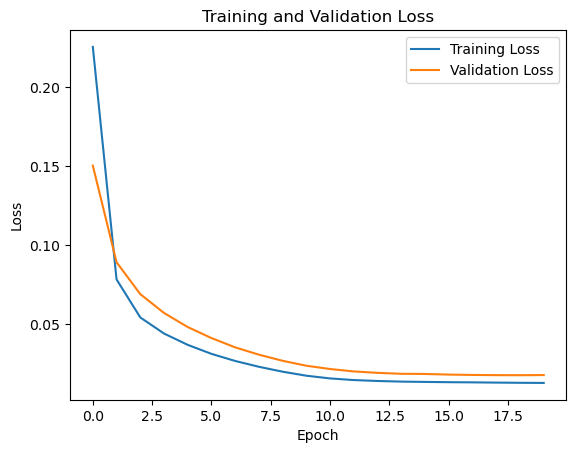

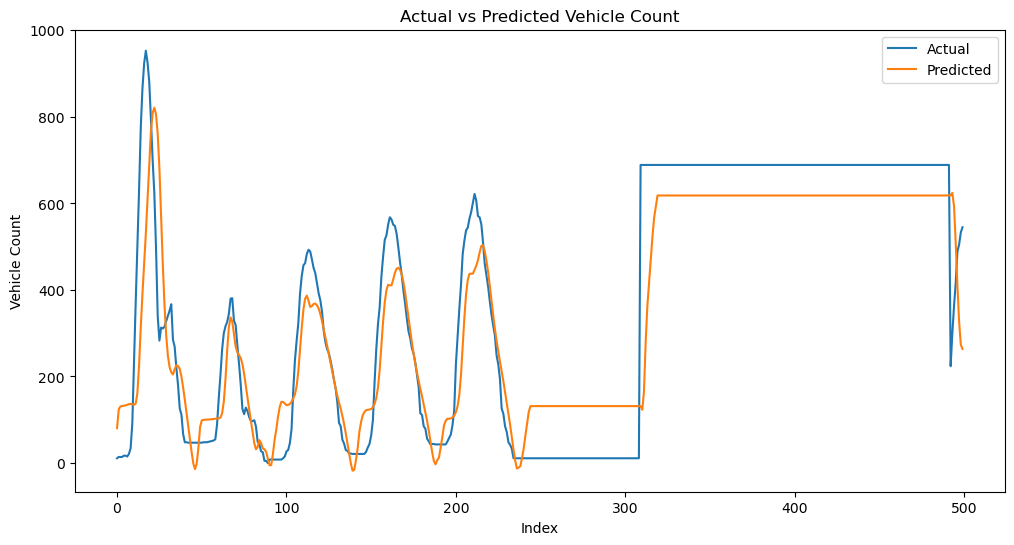

Parking Area: BUSGADEHUSET
Train Loss: 0.0031027509830892086
Test Loss: 0.0015593677526339889
MAE: 19.43200268952743
MSE: 704.1855800097396



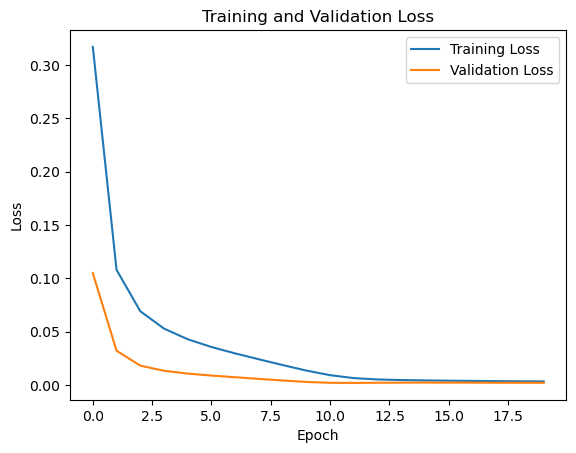

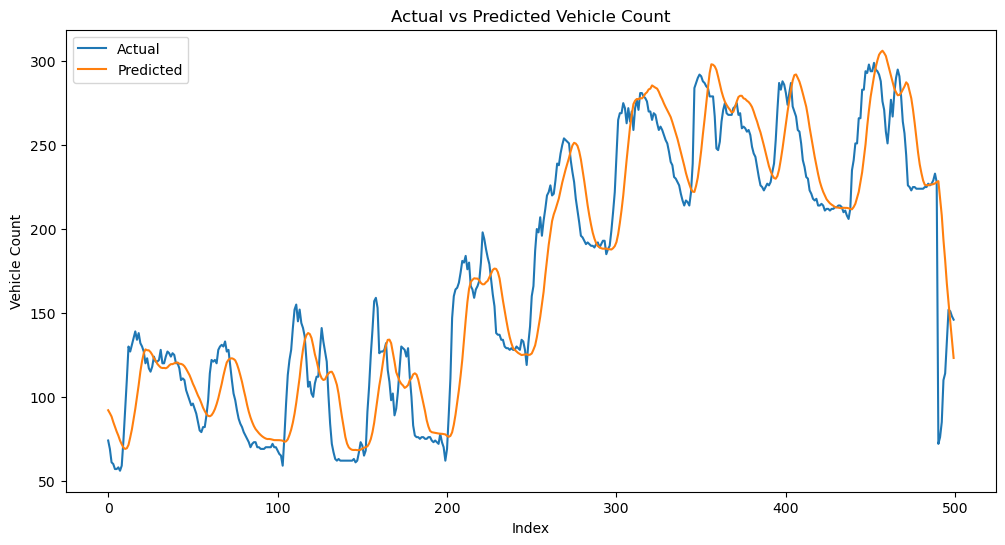

Parking Area: KALKVAERKSVEJ
Train Loss: 0.005407377146184444
Test Loss: 0.007857851684093475
MAE: 9.585932622526004
MSE: 237.90430578573225



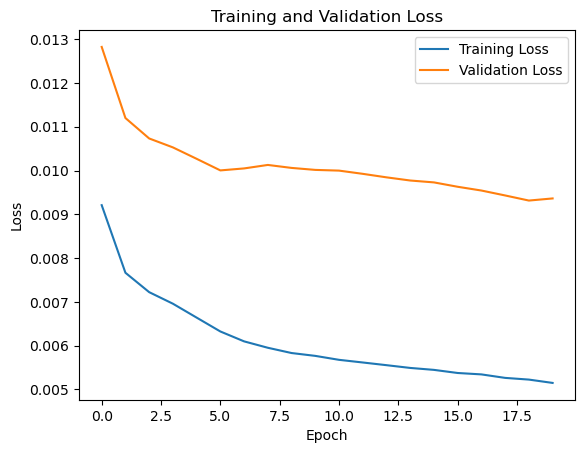

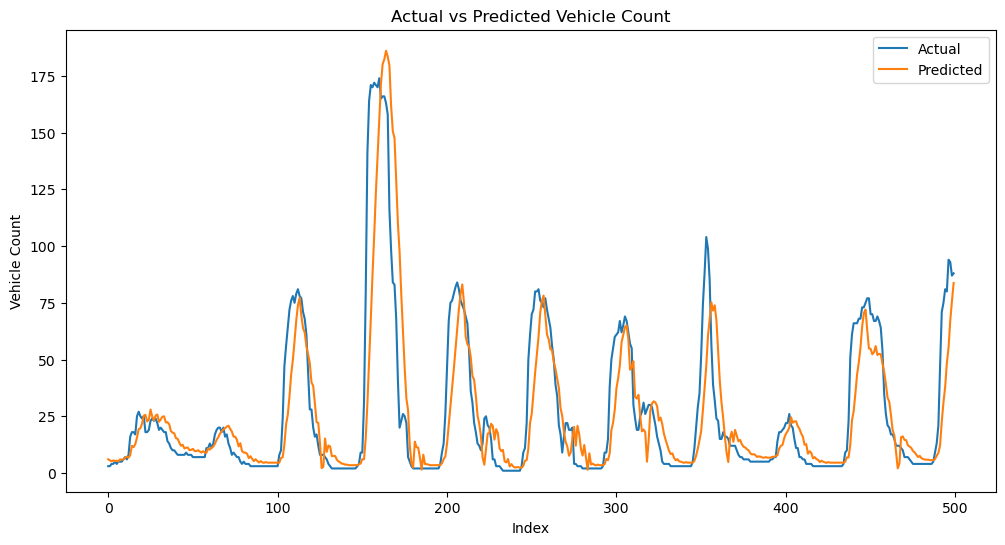

Parking Area: MAGASIN
Train Loss: 0.03319840505719185
Test Loss: 0.037436146289110184
MAE: 54.67732745460842
MSE: 5349.025602778115



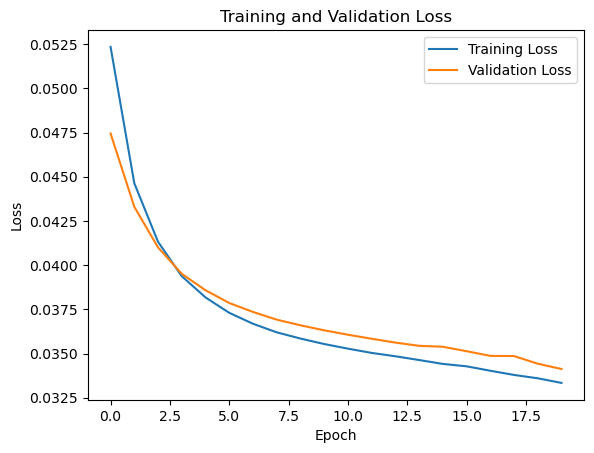

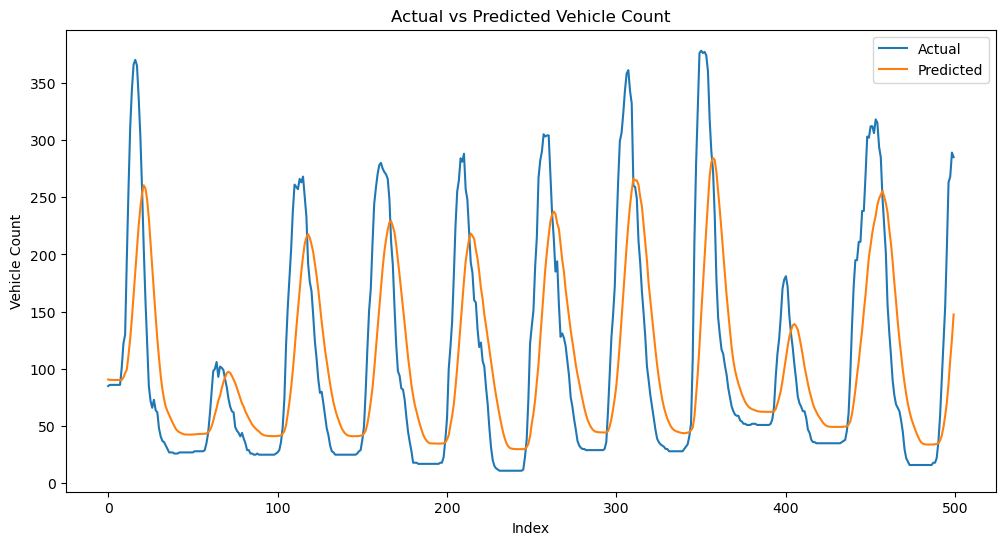

Parking Area: NORREPORT
Train Loss: 0.00020626778132282197
Test Loss: 3.905783160007559e-05
MAE: 6.943150579065517
MSE: 83.71250210229927



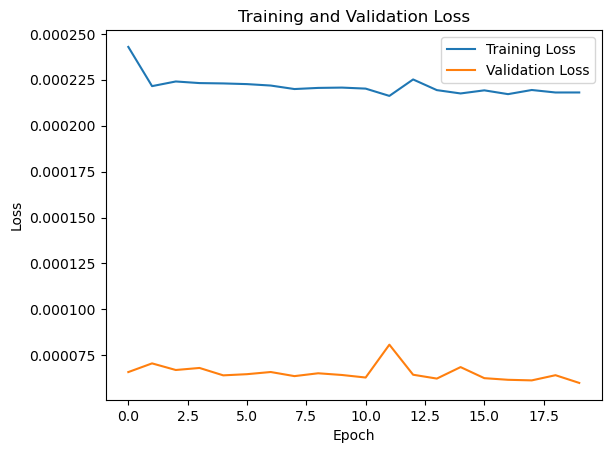

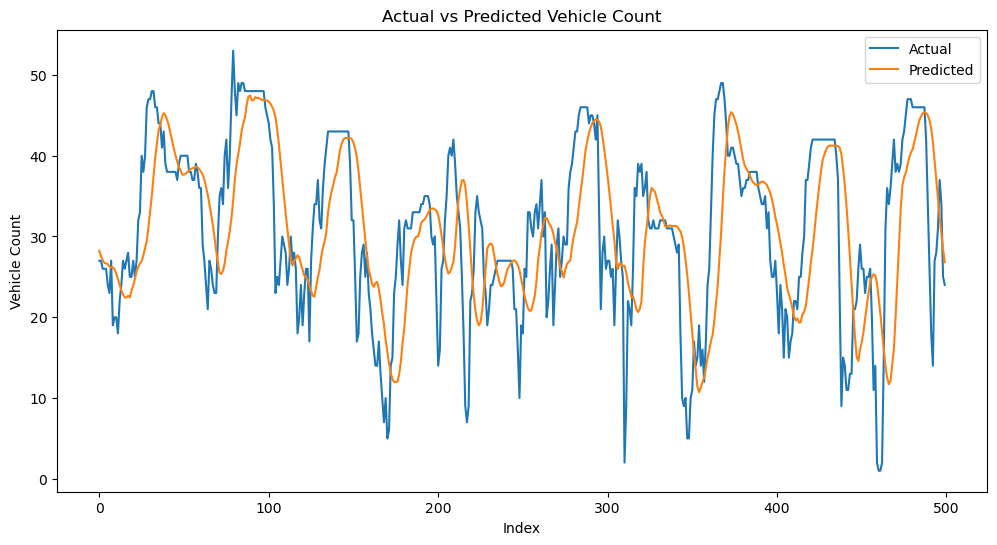

Parking Area: SALLING
Train Loss: 0.020057009533047676
Test Loss: 0.026582196354866028
MAE: 83.02761126393857
MSE: 13025.275689626804



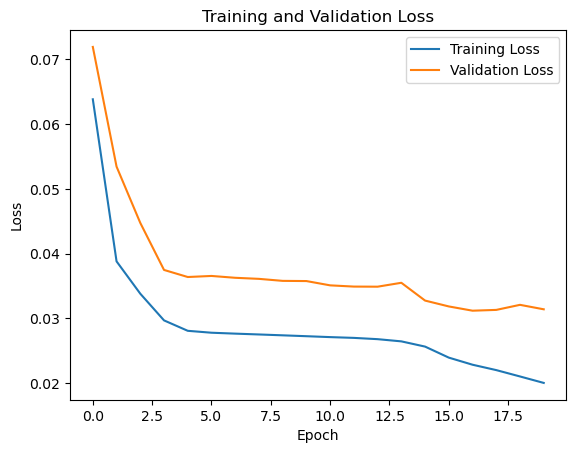

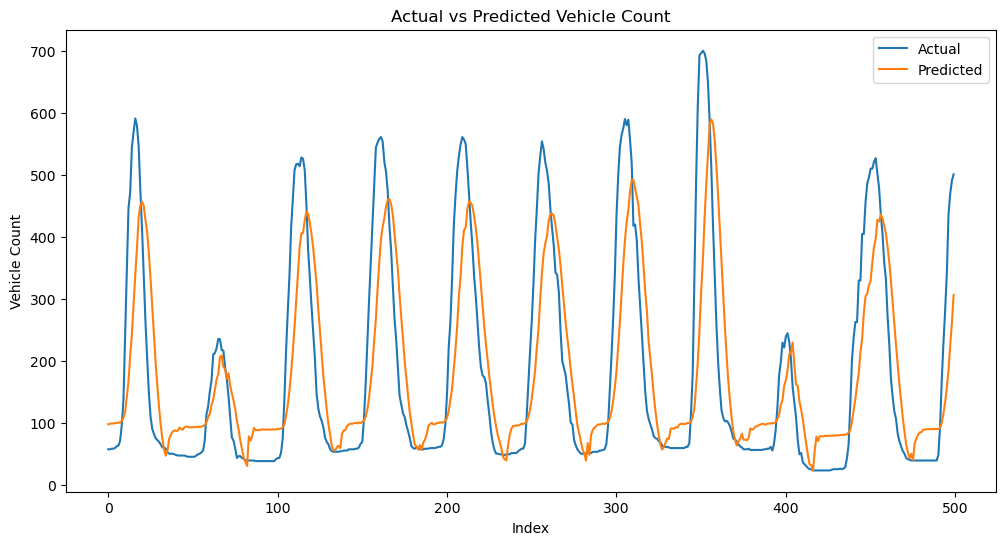

Parking Area: SCANDCENTER
Train Loss: 0.027528876438736916
Test Loss: 0.035434018820524216
MAE: 163.41974028435305
MSE: 46780.02967217653



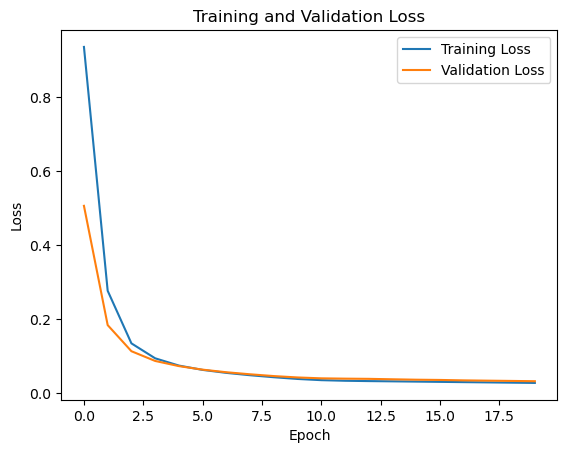

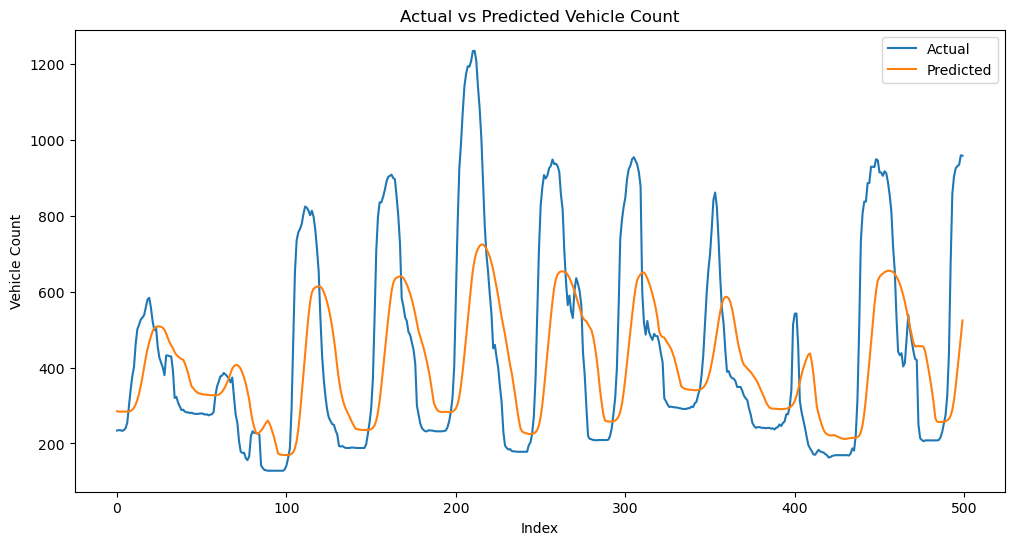

Parking Area: SKOLEBAKKEN
Train Loss: 0.0008772449800744653
Test Loss: 1.0801992402775795e-06
MAE: 0.533172607421875
MSE: 0.28427302930504084



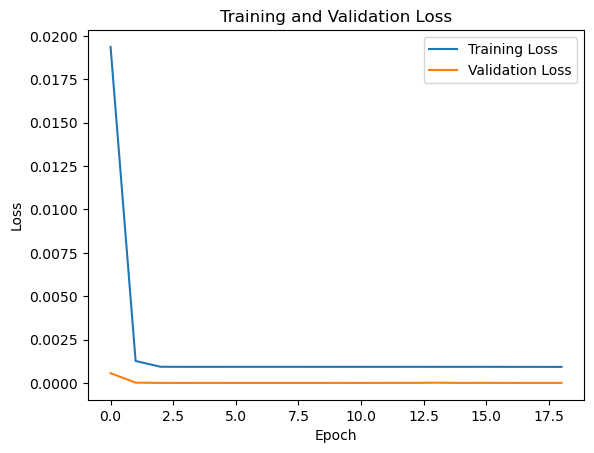

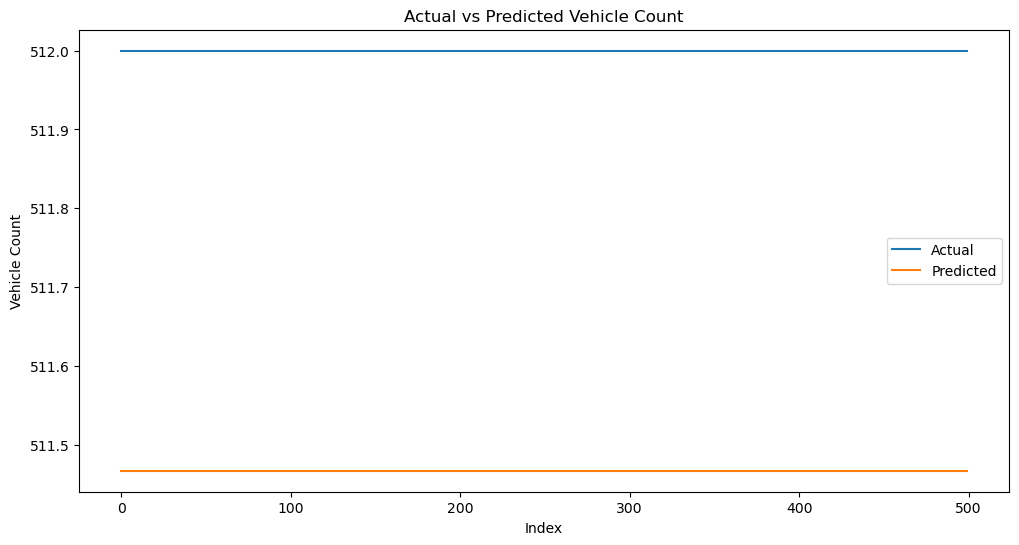

In [89]:
# Print results
for area_id, rnn_result in rnn_results.items():
    print(f"Parking Area: {area_id}")
    print(f"Train Loss: {rnn_result['train_loss']}")
    print(f"Test Loss: {rnn_result['test_loss']}")
    print(f"MAE: {rnn_result['mae']}")
    print(f"MSE: {rnn_result['mse']}")
    print()
    # Plot training and validation loss
    visualize_loss(rnn_result['loss'], rnn_result['val_loss'])

    # Plot actual vs predicted vehicle count
    visualize_model(rnn_result['y_test'], rnn_result['y_test_pred'])

In [90]:
# Display comparative results for LSTM and RNN
results_df = pd.DataFrame(results).T[['mse', 'mae']]
results_rnn_df = pd.DataFrame(rnn_results).T[['mse', 'mae']]
results_df.columns = ['LSTM MSE', 'LSTM MAE']
results_rnn_df.columns = ['RNN MSE', 'RNN MAE']
results_df = pd.concat([results_df, results_rnn_df], axis=1)
results_df

LSTM MSE    LSTM MAE       RNN MSE    RNN MAE
BRUUNS          97237.59668  297.562269  18758.984925  96.775647
BUSGADEHUSET     806.679323   23.158174     704.18558  19.432003
KALKVAERKSVEJ    164.388025    7.316454    237.904306   9.585933
MAGASIN         2658.406677   39.177857   5349.025603  54.677327
NORREPORT         316.94967   14.517003     83.712502   6.943151
SALLING        12509.753426  106.892237   13025.27569  83.027611
SCANDCENTER    19120.374365  128.052013  46780.029672  163.41974
SKOLEBAKKEN     2178.691231   46.676453      0.284273   0.533173